In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import savgol_filter

### DataFrame函數

df.head()   #顯示前五筆資料

df.tail()   #顯示後五筆資料

df.info()   #顯示欄位型別與缺漏值

df.dropna() #移除缺失值列（NaN）

df.fillna(0)#把NaN補0

## 開始做嘍

In [6]:
file_path = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv"
#使用pandas的read_csv讀取tsv檔案,作為一個資料表(dataframe)
#sep="\t"表示分隔符號是tab鍵,skiprows=5表示跳過前5行
df = pd.read_csv(file_path, sep="\t", skiprows=5)

In [7]:
#清理欄位的名字
#df.columns是指欄位名稱的列表
#每個欄位名稱都去除前後空白和#符號
df.columns = [col.strip().lstrip('#').strip() for col in df.columns]

In [8]:
#確保兩欄都是數值
#pd.to_numeric是將欄位轉換為數值型態(float或int)
#errors="coerce"表示如果轉換失敗，則將該值設為NaN
df[df.columns[0]] = pd.to_numeric(df[df.columns[0]], errors="coerce")
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors="coerce")

df[df.columns[1]] = df[df.columns[1]] * 1000  #將第二欄的值乘以1000，轉換為mJy/beam
#刪除任何包含NaN的行
df = df.dropna()

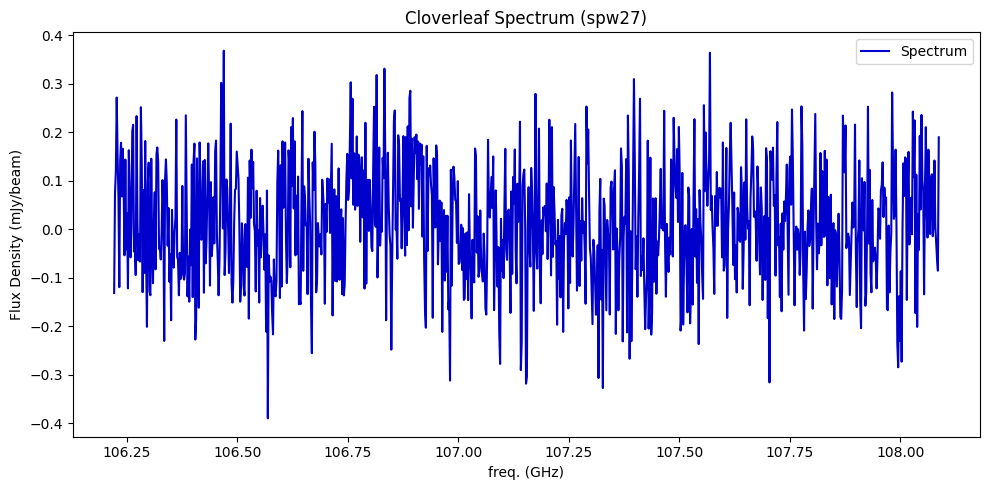

In [9]:
#先畫一個沒平滑過的
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Spectrum", color="mediumblue")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Cloverleaf Spectrum (spw27)")
plt.grid(False)
plt.legend()      #圖例
plt.tight_layout()#自動排版
plt.show()

In [14]:
#平滑（高斯濾波,12個sigma）
y_gauss = gaussian_filter1d(df[df.columns[1]], sigma=8)
y_gauss = y_gauss * 1000  #將平滑後的值乘以1000，轉換為mJy/beam

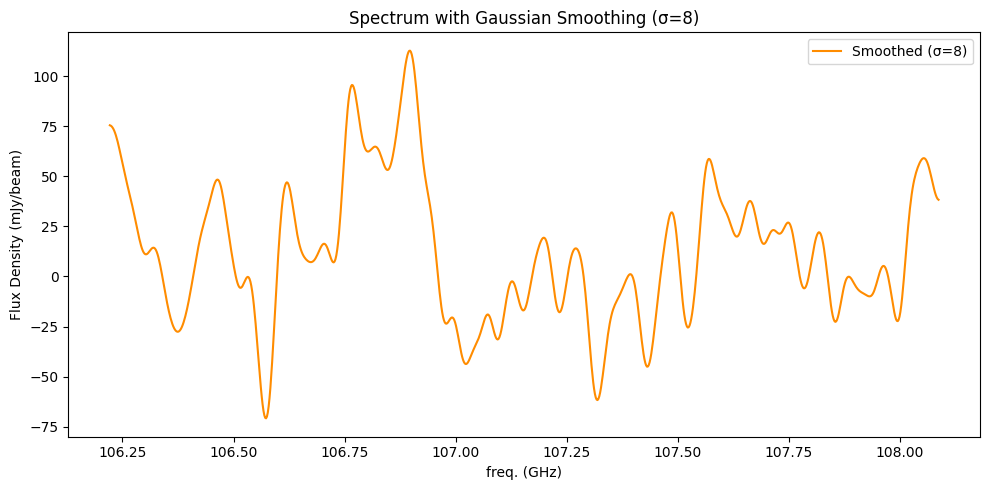

In [16]:
plt.figure(figsize=(10, 5))
#plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original Spectrum", color="mediumblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_gauss, label="Smoothed (σ=8)", color="darkorange")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum with Gaussian Smoothing (σ=8)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
#加入譜線(沒存到HAHA)
#line_file = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv.tsv"
#df_lines = pd.read_csv(file_path, sep="\t", skiprows=5)
#df_lines.columns = [col.strip().lstrip('#').strip() for col in df_lines.columns]
#line_positions = pd.to_numeric(df_lines[df_lines.columns[0]], errors="coerce").dropna()

#換成手打   (freq, label)
my_lines = [(106.857,"H2O")]

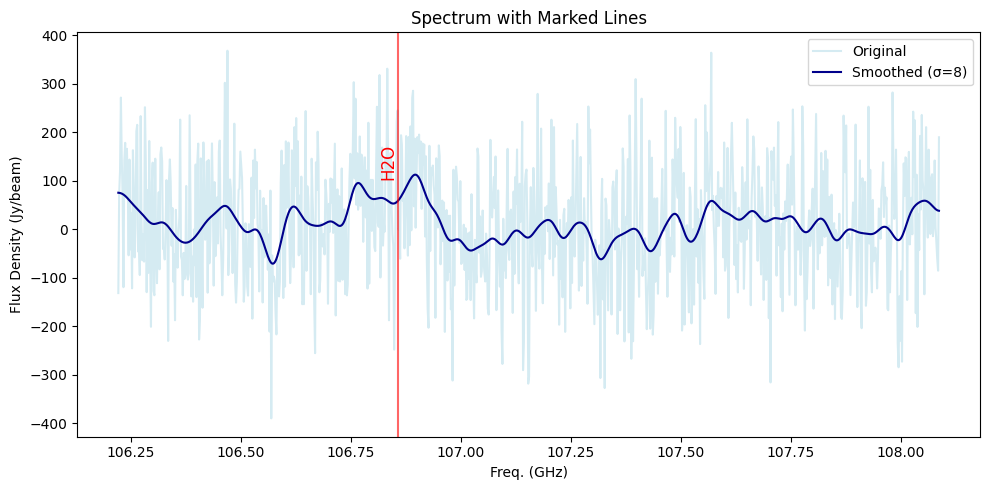

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]] * 1000, label="Original", color="lightblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_gauss, label="Smoothed (σ=8)", color="darkblue")
for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='bottom')
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum with Marked Lines")
plt.legend()
plt.tight_layout()
plt.show()


### 測試拉，不知道可不可以成功

### binning

In [23]:
x = df[df.columns[0]].values  #第一欄是頻率
y = df[df.columns[1]].values * 1000  #第二欄是flux density

#binning smoothing
def rebin_spectrum(x, y, bin_size):
    n_bins = len(y) // bin_size
    x = x[:n_bins * bin_size]
    y = y[:n_bins * bin_size]
    x_binned = x.reshape(n_bins, bin_size).mean(axis=1)
    y_binned = y.reshape(n_bins, bin_size).mean(axis=1)
    return x_binned, y_binned

x_bin, y_bin = rebin_spectrum(x, y, bin_size=4)
y_bin = y_bin

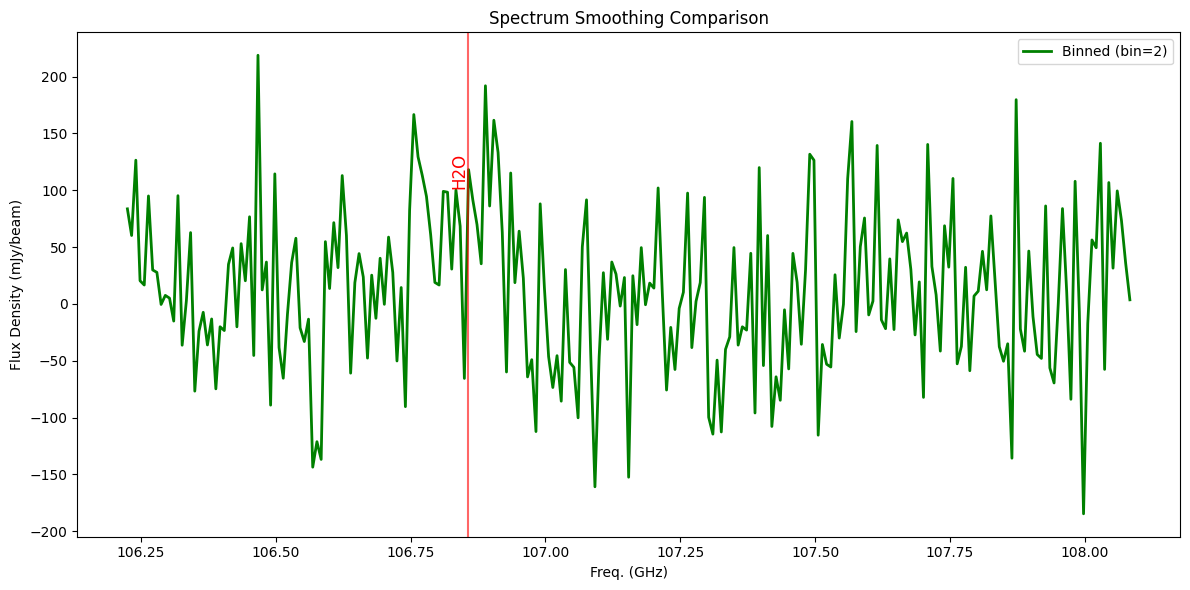

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(x_bin, y_bin, label="Binned (bin=2)", color="green", linewidth=2)

for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='bottom')

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### boxcar smoothing

In [25]:
#boxcar smoothing
def boxcar_smooth(y, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(y, kernel, mode='same')

y_boxcar = boxcar_smooth(y, kernel_size=30)
#y_boxcar = y_boxcar * 1000  #將第二欄的值乘以1000，轉換為mJy/beam



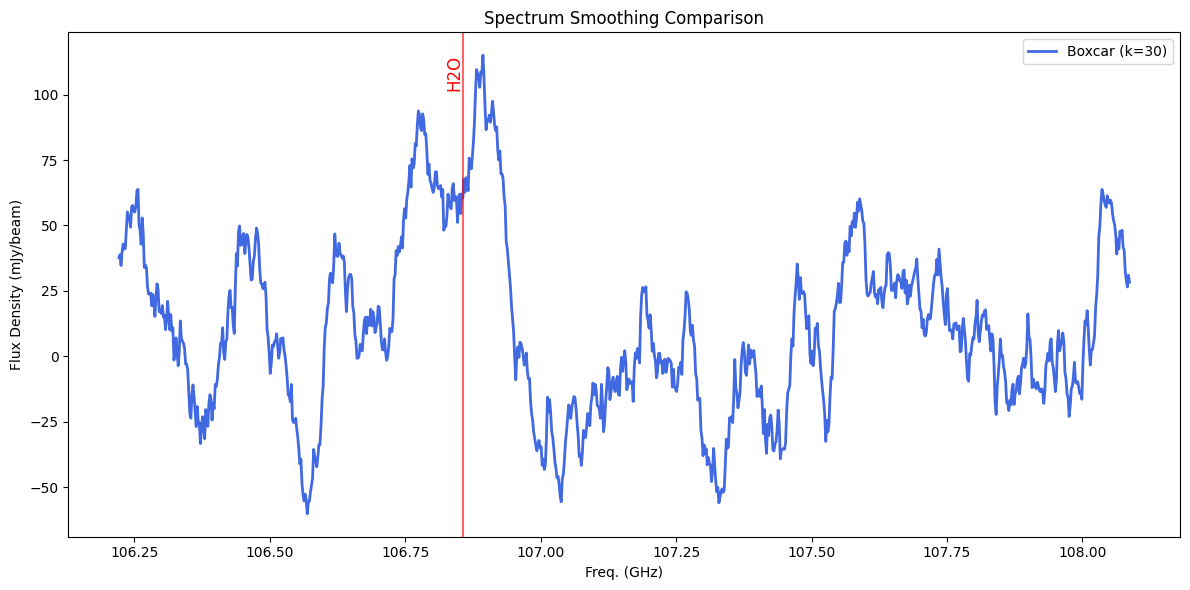

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(x, y_boxcar, label="Boxcar (k=30)", color="royalblue", linewidth=2)

for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='bottom')
    
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### Savitzky-Golay Filter

In [27]:
def GZ_smooth(y, window_length=21, polyorder=2):
    return savgol_filter(y, window_length=window_length, polyorder=polyorder)

y_savgol = GZ_smooth(y, window_length=21, polyorder=1)

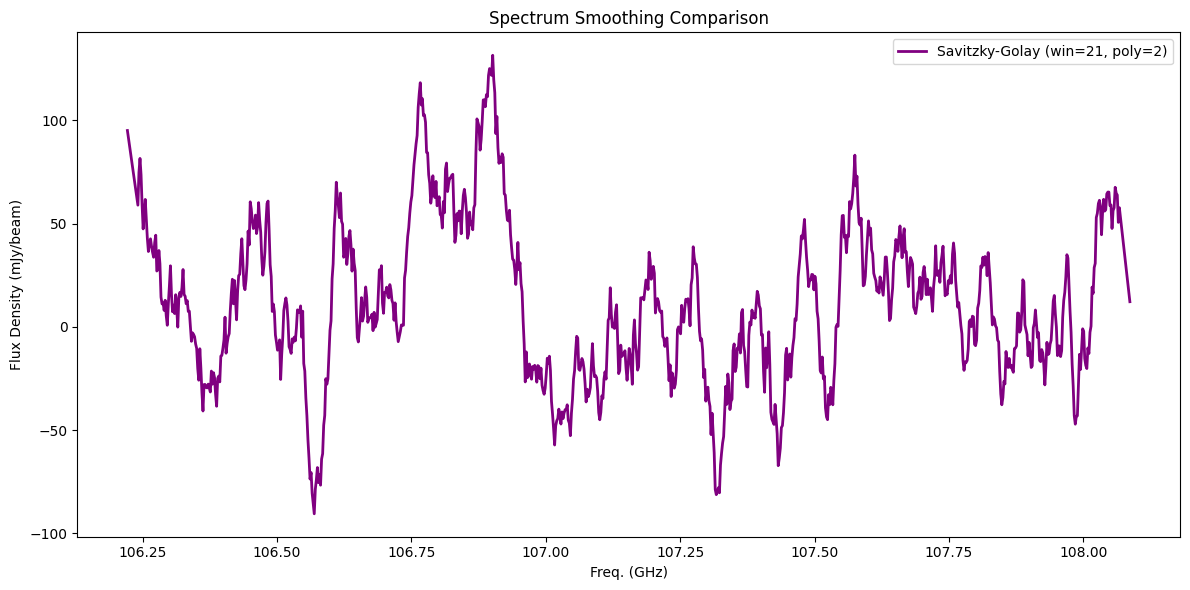

In [28]:
plt.figure(figsize=(12, 6))

plt.plot(x, y_savgol, label="Savitzky-Golay (win=21, poly=2)", color="purple", linewidth=2)

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### 全部放在一起

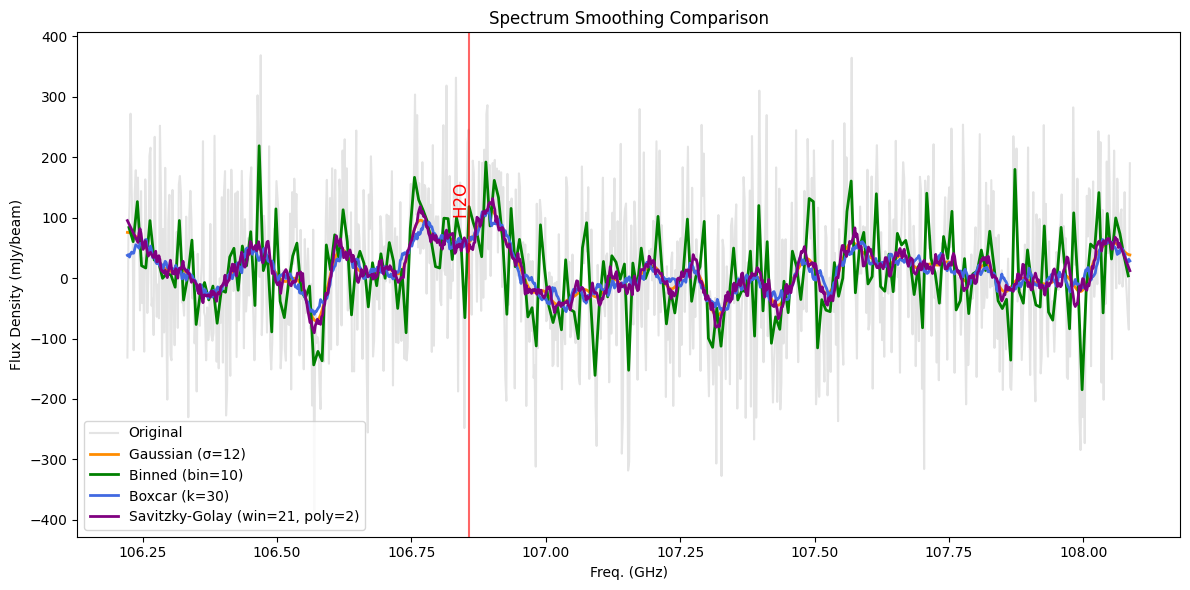

In [29]:
# 比較看看吧
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Original", color="lightgray", alpha=0.6)
plt.plot(x, y_gauss, label="Gaussian (σ=12)", color="darkorange", linewidth=2)
plt.plot(x_bin, y_bin, label="Binned (bin=10)", color="green", linewidth=2)
plt.plot(x, y_boxcar, label="Boxcar (k=30)", color="royalblue", linewidth=2)
plt.plot(x, y_savgol, label="Savitzky-Golay (win=21, poly=2)", color="purple", linewidth=2)

for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='bottom')

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### 我想要同時binning + boxcar 試看看嘍

In [30]:
#先做binning smoothing 再加入boxcar smoothing??
x = df[df.columns[0]].values  #第一欄是頻率
y = df[df.columns[1]].values * 1000  #第二欄是flux density

#binning
x_bin, y_bin = rebin_spectrum(x, y, bin_size=5)
y_bin = y_bin

#boxcar
y_bin_boxcar = boxcar_smooth(y_bin, kernel_size=8)


C:\Users\USER\AppData\Local\Temp\ipykernel_54772\1197501009.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


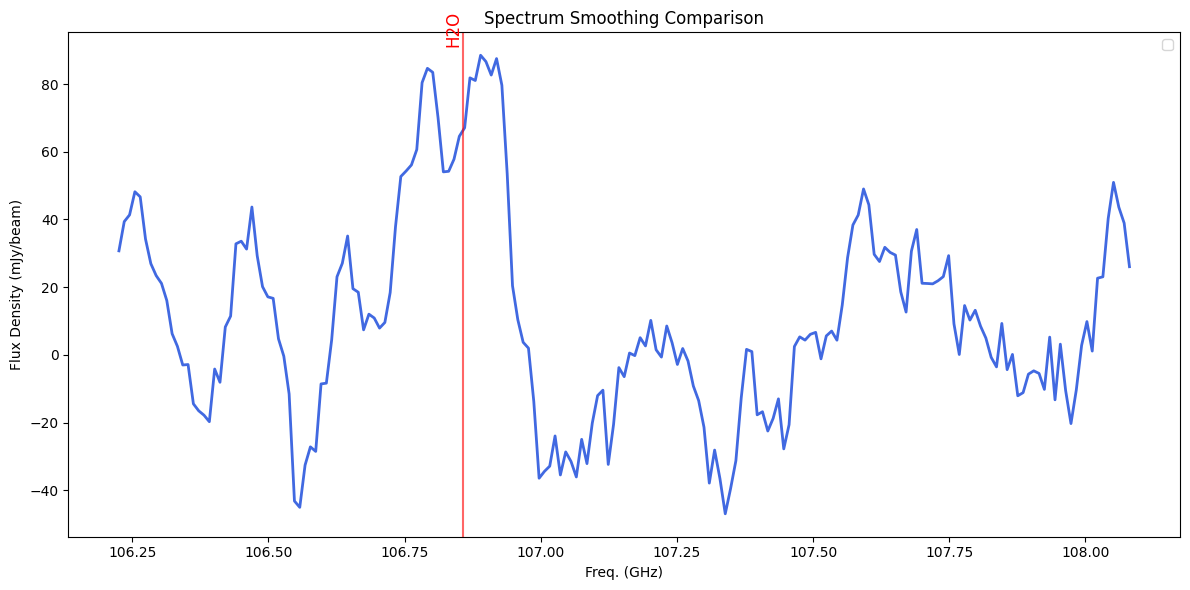

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(x_bin, y_bin_boxcar, color="royalblue", linewidth=2)

for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='top')

plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### 阿如果我在加SGFㄌㄟ

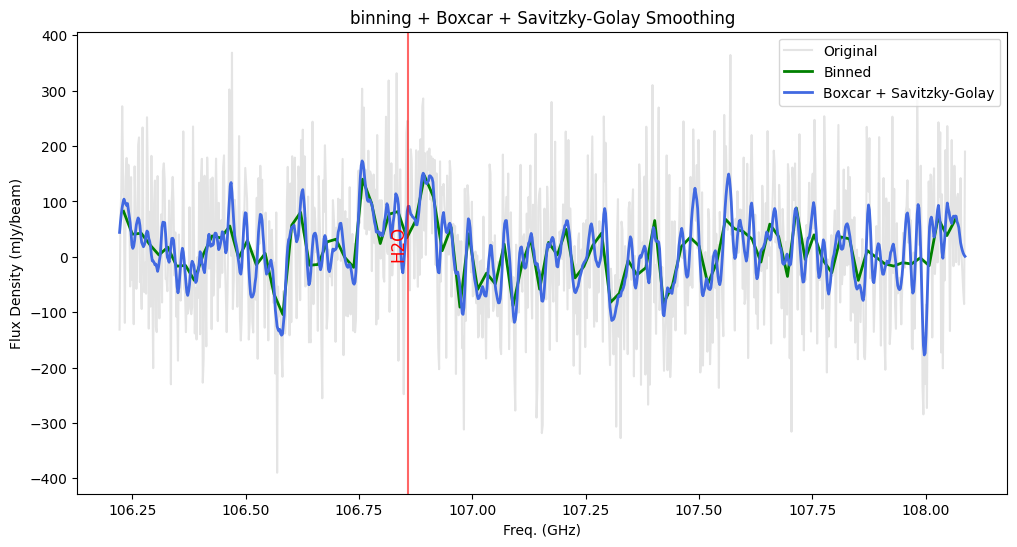

In [32]:
#binning
x_bin, y_bin = rebin_spectrum(x, y, bin_size=10)
y_bin = y_bin

#boxcar
y_bin_boxcar = boxcar_smooth(y_bin, kernel_size=3)

#Savitzky-Golay
y_bin_boxcar_savgol = GZ_smooth(y_bin_boxcar, window_length=11, polyorder=2)

#隨便拉，我要SGF+boxcar
y_boxcar = boxcar_smooth(y, kernel_size=5)
y_boxcar_savgol = GZ_smooth(y_boxcar, window_length=11, polyorder=2)

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Original", color="lightgray", alpha=0.6)
plt.plot(x_bin, y_bin, label="Binned", color="green", linewidth=2)
#plt.plot(x_bin, y_bin_boxcar_savgol, label="three way combine", color="purple", linewidth=2)
plt.plot(x, y_boxcar_savgol, label="Boxcar + Savitzky-Golay", color="royalblue", linewidth=2)
for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.5, label, rotation=90, color="red", fontsize=12, ha='right', va='top')
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("binning + Boxcar + Savitzky-Golay Smoothing")
plt.legend()

## 簡單說明

### binning：

把一堆細點點，以(你設定的數)個一組平均，得到平滑穩定的結果

所以他資料量會變少->解析度變差，但S/N變高

適用在想要提升S/N、可犧牲解析度的時候

### boxcar smoothing：

拿一個kernel（通常是uniform）捲積資料，基本上等效於滑動平均

讓資料變得更平滑，但資料點通常不變（除了邊緣可能有異動）

所以解析度還是可能下降（訊號便平均攤平了）

kernel size代表說：我一次要平均幾個資料點？

例如：kernel = 3就是指我決定用當前的點點+他左右鄰居各1人（共3點）當成自己新的數值

kernel小(3-5)輕微平滑、表示細節重要

kernel中(7-15)中等平滑、有明顯雜訊需降躁

kernel大( >20)大平滑、只看整體趨勢

### Savitzky-Golay Filter：

平滑雜訊但保留尖峰和結構的方法

window_length：一次看的資料點範圍，要是奇數，因為是拿他這一點為中心，抓多少數據做擬合

polyorder：用幾次多項式擬合上面設定的點點數（0就是取平均）

看要不要先做binning再做boxcar smoothing

binning之後，前後資料是沒有關聯的

再來做boxcar smoothing，平滑前後的資料

## 上面先忽略，來做binnig + boxcar的

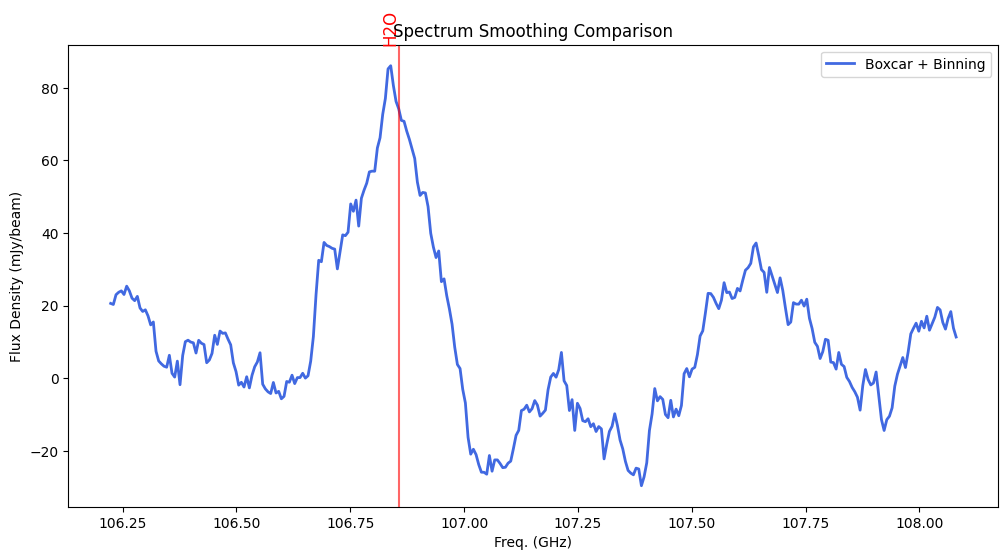

In [43]:
#binning
x_bin, y_bin = rebin_spectrum(x, y, bin_size=3)
y_bin = y_bin

#boxcar
y_bin_boxcar = boxcar_smooth(y_bin, kernel_size=30)

plt.figure(figsize=(12, 6))
plt.plot(x_bin, y_bin_boxcar, label="Boxcar + Binning", color="royalblue", linewidth=2)
for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_gauss)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='top')
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.legend()